Dataset splits: Train=29399, Val=6300, Test=6301
Epoch 1/30 | Train loss: 1.2594, Train acc: 0.6745 | Val loss: 0.6114, Val acc: 0.8463
Epoch 2/30 | Train loss: 0.4859, Train acc: 0.8718 | Val loss: 0.4203, Val acc: 0.8835
Epoch 3/30 | Train loss: 0.3737, Train acc: 0.8978 | Val loss: 0.3588, Val acc: 0.8989
Epoch 4/30 | Train loss: 0.3271, Train acc: 0.9066 | Val loss: 0.3261, Val acc: 0.9067
Epoch 5/30 | Train loss: 0.2987, Train acc: 0.9147 | Val loss: 0.3047, Val acc: 0.9100
Epoch 6/30 | Train loss: 0.2785, Train acc: 0.9192 | Val loss: 0.2941, Val acc: 0.9156
Epoch 7/30 | Train loss: 0.2620, Train acc: 0.9254 | Val loss: 0.2759, Val acc: 0.9213
Epoch 8/30 | Train loss: 0.2483, Train acc: 0.9292 | Val loss: 0.2658, Val acc: 0.9237
Epoch 9/30 | Train loss: 0.2365, Train acc: 0.9322 | Val loss: 0.2603, Val acc: 0.9263
Epoch 10/30 | Train loss: 0.2253, Train acc: 0.9354 | Val loss: 0.2529, Val acc: 0.9284
Epoch 11/30 | Train loss: 0.2164, Train acc: 0.9382 | Val loss: 0.2408, Val acc:

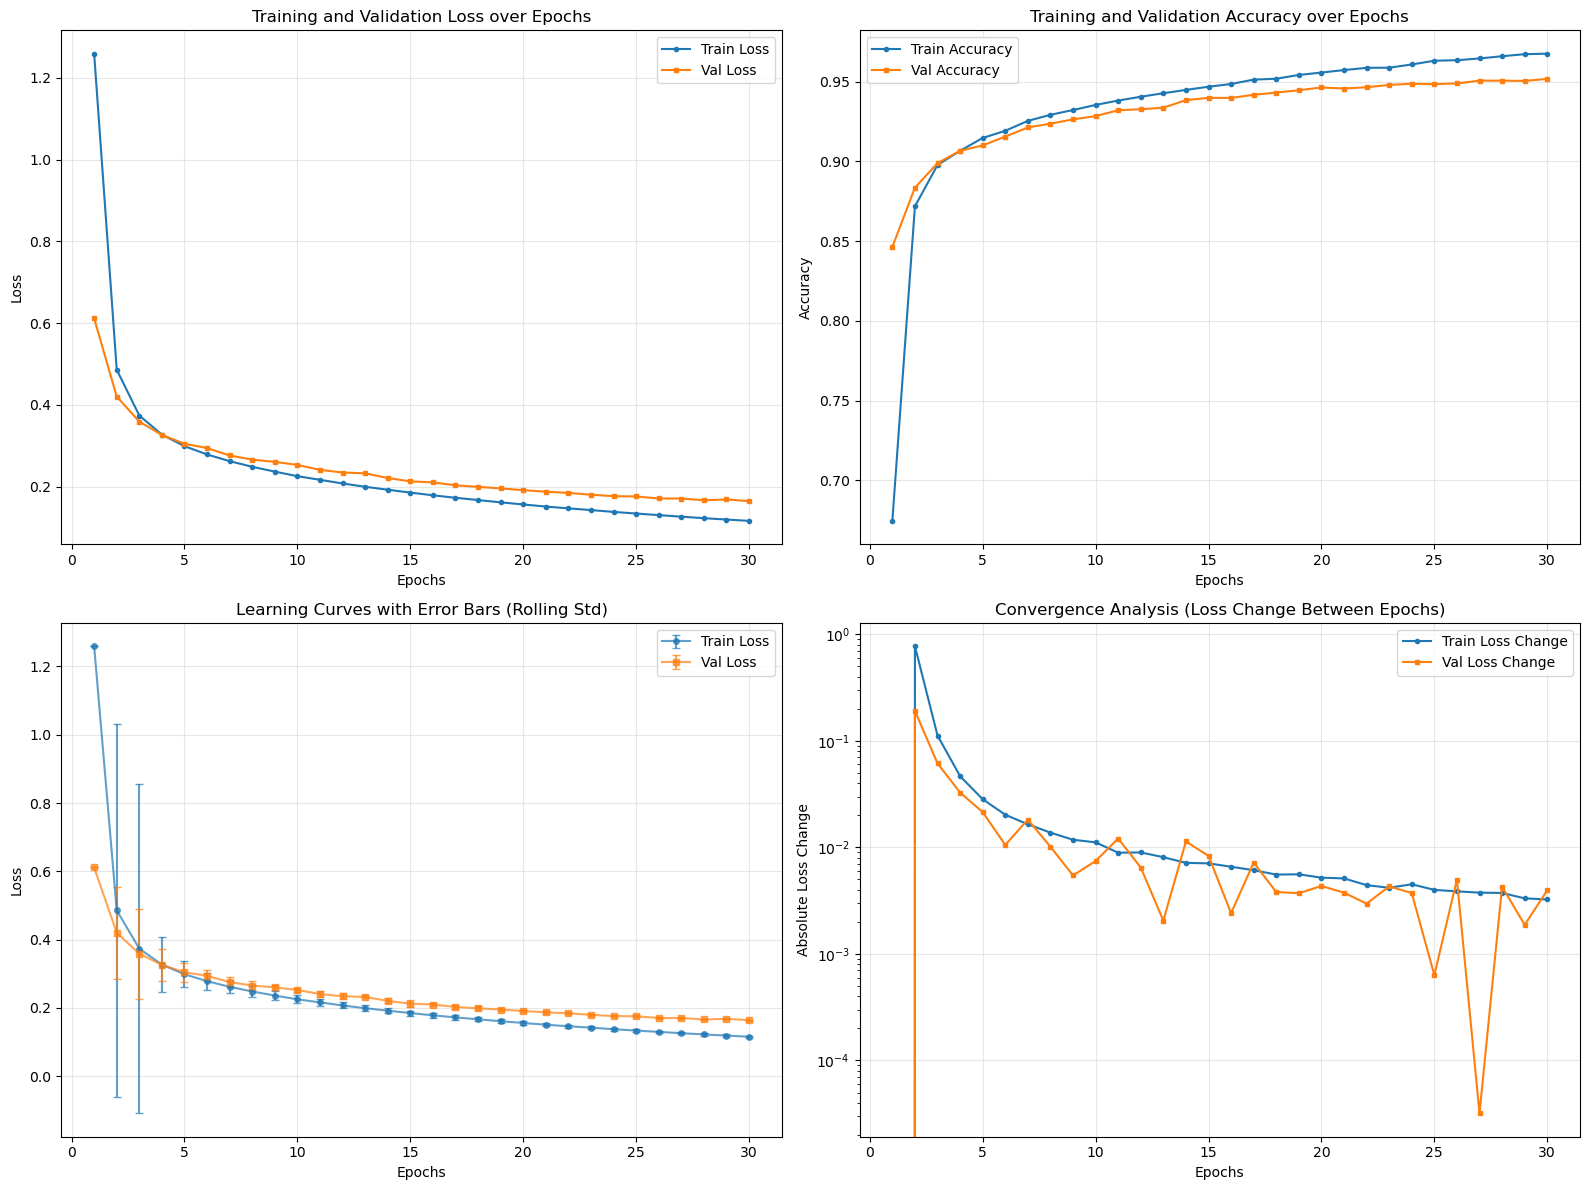

Test accuracy: 0.9514


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt

# --- Neural Network Definition ---

class CustomNet(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(CustomNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, output_size)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# --- Load Dataset from CSV with Shape Validation ---

def load_dataset(csv_path):
    df = pd.read_csv(csv_path)
    if df.shape[1] != 785:
        raise ValueError(f"Expected 785 columns (1 label + 784 pixels) but got {df.shape[1]} in {csv_path}")
    
    labels = df.iloc[:, 0].values
    pixels = df.iloc[:, 1:].values.astype('float32')
    
    # Normalize to [0,1]
    pixels /= 255.0  
    
    if pixels.shape[1] != 784:
        raise ValueError(f"Expected 784 pixel features but got {pixels.shape[1]} in {csv_path}")
    
    X = torch.tensor(pixels)
    y = torch.tensor(labels, dtype=torch.long)
    return TensorDataset(X, y)

# --- Training Loop with Validation ---

def train_model(model, train_dataset, val_dataset, batch_size=64, epochs=30, learning_rate=0.01):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        train_loss = total_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
        val_loss /= val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f} | "
              f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")
        
    return train_losses, train_accs, val_losses, val_accs

# --- Plot Results ---

def plot_performance(train_losses, train_accs, val_losses, val_accs):
    epochs = range(1, len(train_losses) + 1)
    
    # Create a 2x2 grid of plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Training and Validation Loss over Epochs
    axes[0, 0].plot(epochs, train_losses, label='Train Loss', marker='o', markersize=3)
    axes[0, 0].plot(epochs, val_losses, label='Val Loss', marker='s', markersize=3)
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss over Epochs')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Training and Validation Accuracy over Epochs
    axes[0, 1].plot(epochs, train_accs, label='Train Accuracy', marker='o', markersize=3)
    axes[0, 1].plot(epochs, val_accs, label='Val Accuracy', marker='s', markersize=3)
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Training and Validation Accuracy over Epochs')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Learning Curves with Error Bars (showing variance across epochs)
    # Calculate rolling standard deviation as error estimate
    window = 3
    train_loss_std = pd.Series(train_losses).rolling(window=window, min_periods=1).std().fillna(0)
    val_loss_std = pd.Series(val_losses).rolling(window=window, min_periods=1).std().fillna(0)
    
    axes[1, 0].errorbar(epochs, train_losses, yerr=train_loss_std, label='Train Loss', 
                        fmt='-o', markersize=4, capsize=3, alpha=0.7)
    axes[1, 0].errorbar(epochs, val_losses, yerr=val_loss_std, label='Val Loss', 
                        fmt='-s', markersize=4, capsize=3, alpha=0.7)
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].set_title('Learning Curves with Error Bars (Rolling Std)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Convergence Analysis (Loss difference between consecutive epochs)
    train_loss_diff = [0] + [abs(train_losses[i] - train_losses[i-1]) for i in range(1, len(train_losses))]
    val_loss_diff = [0] + [abs(val_losses[i] - val_losses[i-1]) for i in range(1, len(val_losses))]
    
    axes[1, 1].plot(epochs, train_loss_diff, label='Train Loss Change', marker='o', markersize=3)
    axes[1, 1].plot(epochs, val_loss_diff, label='Val Loss Change', marker='s', markersize=3)
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Absolute Loss Change')
    axes[1, 1].set_title('Convergence Analysis (Loss Change Between Epochs)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_yscale('log')  # Log scale to better see convergence
    
    plt.tight_layout()
    plt.show()

# --- Evaluate on Test Dataset ---

def test_model(model, test_dataset, batch_size=64):
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = correct / total
    print(f"Test accuracy: {test_acc:.4f}")
    return test_acc

# --- Main Execution ---

if __name__ == '__main__':
    # Path to CSV file
    train_csv_path = "train.csv"
    
    # Load full dataset
    full_dataset = load_dataset(train_csv_path)
    
    # Split into train (70%), validation (15%), and test (15%)
    total_size = len(full_dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, 
        [train_size, val_size, test_size]
    )
    
    print(f"Dataset splits: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")
    
    # Model parameters
    input_size = 784  # MNIST flattened
    hidden1_size = 128
    hidden2_size = 64
    output_size = 10  # digits 0-9
    
    # Create model
    model = CustomNet(input_size, hidden1_size, hidden2_size, output_size)
    
    # Train model with validation split
    train_losses, train_accs, val_losses, val_accs = train_model(
        model, train_dataset, val_dataset,
        batch_size=64,
        epochs=30,
        learning_rate=0.01
    )
    
    # Plot training and validation performance
    plot_performance(train_losses, train_accs, val_losses, val_accs)
    
    # Evaluate on test dataset
    test_acc = test_model(model, test_dataset, batch_size=64)